# "Modulo 5"
> "Analisi DMRG del modello di Ising 1D ad interazioni random"

A differenza dei precedenti moduli in questa relazione non mi occuperò di studiare sistemi con interazioni a lunga distanza random poiché il DMRG si basa fondamentalmente su interazioni a primi vicini. Sono possibili estensioni per considerare interazioni a lungo raggio, ma richiedono un notevole sforzo sia di implementazione che computazionale.

La **Density Matrix Renormalization Group** è una tecnica numerica iterativa che consente di trovare il ground state, ed eventualmente pochi altri stati eccitati, di un sistema quantistico a bassa dimensionalità in una maniera estremamente efficiente. 
È un metodo approssimato che si ispira alla rinormalizzazione numerica alla Wilson, ma il cui funzionamento si basa sull'*entanglement bipartito* per il ground state di $\hat{H}$, condizione sufficiente per la validità dell'*Area Law*. Considerando uno stato puro $|\psi⟩_{AB}$ di un sistema quantistico bipartito AB, questa proprietà, dimostrata per il caso 1D e presa come congettura per il caso 2D, esprime la dipendenza dell'entropia di Von Neumann della partizione A dalla dimensione del confine tra A e B.
$$ S(\rho_A) \sim dim(bound(A|B))$$
in cui 
$$\rho_A = Tr_B(|\psi⟩_{AB}⟨\psi|)$$






Una generica Hamiltoniana che soddisfa queste condizioni può essere scritta come:

### $$ \hat{H}=\sum_{i=1}^L ( \sum_\alpha J_i^{(\alpha)} \hat{S}_i^{(\alpha)} \hat{T}_{i+1}^{(\alpha)} +\sum_\beta B_i^{(\beta)} \hat{V}_i^{(\beta)} ) $$

L'Hamiltoniana del modello di Ising quantistico 1D rientra in questa forma:

## $$ \hat{H} = -\sum_{i}^L J_i\sigma_i^z \sigma_{i+1}^z + g_i \sum_{i}^L \sigma_i^x $$

L'algoritmo del DMRG si articola in **alcuni** step:
1. Si parte da un blocco $B(1,d)$, composto dal solo sito estremo di sinistra, di cui si definisce l'Hamiltoniana $\hat{H}_B$, nel codice *BlockH*. Spazio di Hilbert di dimensione $d$.
2. Si costruisce l'*Enlarged Block* aggiungendo al blocco precedente il sito adiacente destro e si costruisce l'hamiltoniana corrispondente $\hat{H}_E$:
$$ \hat{H}_E = \hat{H}_B \otimes \mathbb{1}_{sito} + \mathbb{1}_B \otimes \hat{H}_{sito} + \hat{H}_{B-sito} $$ Spazio di Hilbert di dimensione $d^2$.
3. Si costruisce il *Super-block* aggiundendo al blocco precedente un blocco speculare, considerando il fatto che il sistema in esame è simmetrico per riflessione rispetto al centro della catena, il collegamento è dato dall'interazione dei due siti esterni aggiunti al passo precedente. L'Hamiltoniana del *Super-block* diventa:
$$ \hat{H}_{SB} = \hat{H}_E \otimes \mathbb{1}_{E'} + \mathbb{1}_E \otimes \hat{H}_{E'} + \hat{H}_{E-E'} $$
4. 
5. 
6. 
7. 
8. 

In [8]:
#collapse
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as ssl
import scipy.sparse as ss

## Infinite-System DMRG per il modello di Ising

Di seguito è presentato il codice che implementa il DMRG per un modello di Ising quantistico. Il codice restituisce i grafici dell'andamento dell'entropia al variare dell'intensità del campo trasverso, parametrizzato da $g$ che varia da 0 a 2. Per ogni run $J_i=J$ e $g_i=g$ sono costanti. Poichè il comportamente del sistema non dipende da entrambe le variabili ma solo dal loro rapporto, consideriamo $J=1$. Ad ogni grafico corrisponde una diversa taglia del sistema.

Si può notare come all'aumentare della taglia il valore di $g$ corrispondente al picco dell'entropia converga ad 1, come previsto teoricamente, ed il picco si alzi diventando sempre più stretto, indicando nel limite termodinamico una transizione di fase.

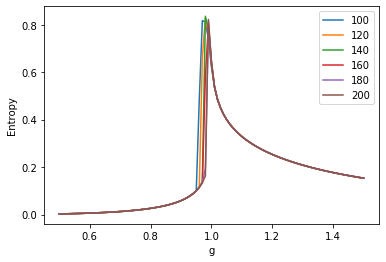

In [10]:
m=9
NIter=200
rep=100
rep+=1
gmax=1.5
ling=np.linspace(0.5,gmax,rep)
linell=2**np.arange(3,8)

Evec=np.zeros(rep)
Entropy=np.zeros(rep)

graphs=np.zeros((rep,NIter))


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
ggg=0

for g in ling:
    BlockSz = Sz
    BlockSx = Sx
    BlockI  = I
    BlockH  = g*Sx
    Energy = 0

    for l in range(NIter):
        SystSize = 2*l + 4

    # Get the 2m-dimensional operators for the block + site

        BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - np.kron(BlockSz, Sz) 
        BlockSz = np.kron(BlockI, Sz)
        BlockSx = np.kron(BlockI, Sx)
        BlockI  = np.kron(BlockI, I)

    # HAMILTONIAN MATRIX for superblock
        H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - np.kron(BlockSz, BlockSz)
        H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

    # Diagonalizing the Hamiltonian
        LastEnergy = Energy
        Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
        Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
        EnergyPerBond = (Energy - LastEnergy) / 2
        Ener2 = Energy / SystSize


    # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

    # Form the reduced density matrix
        nr=Psi.size
        Dim = int(np.sqrt(nr))
        PsiMatrix = np.reshape(Psi,(Dim,Dim))
        Rho = PsiMatrix @ PsiMatrix.T

    # Diagonalize the density matrix
        D,V = np.linalg.eigh(Rho)
        D=D[::-1]  # descending
        Index=np.arange(Dim)
        Index=Index[::-1]
        V=V[:,Index]

    # Construct the truncation operator
        NKeep = min(D.size, m)
        Omatr = V[:,:NKeep]
        TruncationError = 1 - sum(D[:NKeep])
        
        
        Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))

    # Transform the block operators into the truncated basis
        BlockH  = Omatr.T @ BlockH  @ Omatr
        BlockSz = Omatr.T @ BlockSz @ Omatr
        BlockSx = Omatr.T @ BlockSx @ Omatr
        BlockI =  Omatr.T @ BlockI  @ Omatr
        
        graphs[ggg,l]=Ent
        
    ell=SystSize
    
    Evec[ggg]=Energy
    Entropy[ggg]=Ent
    
    ggg+=1

for i in range(5,11):
    plt.plot(ling,graphs[:,2*i*10-1],label=2*i*10)
plt.legend()
plt.xlabel('g')
plt.ylabel('Entropy')
plt.show()

## Interazioni a valori random
Di seguito è riportato il grafico, ed il codice espandibile, di un modello di Ising 1D in cui i valori di $J_i$ non sono tutti uguali ad 1, ma sono estratti random da una distribuzione normale con media 1 e varianza variabile, **riportata nei grafici**.
Ad ogni ciclo sono estratti due numeri random, dalla stessa distribuzione, uno per l'interazione Blocco-Sito ed uno per l'interazione tra due Enlarged Block.

In [ ]:
#collapse
m=8
NIter=200
rep=20
rep+=1
gmax=2
ling=np.linspace(0,gmax,rep)


Evec=np.zeros(rep)
Entropy=np.zeros(rep)
ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
for gm in ling:
    Ent=0
    BlockSz = Sz
    BlockSx = Sx
    BlockI  = I
    BlockH  = gm*Sx
    Energy = 0

    for l in range(NIter):
        SystSize = 2*l + 4

        g=gm
        j1=np.random.default_rng().normal(.1, .1)

    # Get the 2m-dimensional operators for the block + site

        BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - j1*np.kron(BlockSz, Sz) 
        BlockSz = np.kron(BlockI, Sz)
        BlockSx = np.kron(BlockI, Sx)
        BlockI  = np.kron(BlockI, I)

    # HAMILTONIAN MATRIX for superblock
        j2=np.random.default_rng().normal(.1, .1)

        H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - j2*np.kron(BlockSz, BlockSz)
        H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

    # Diagonalizing the Hamiltonian
        LastEnergy = Energy
        Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
        Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
        EnergyPerBond = (Energy - LastEnergy) / 2
        Ener2 = Energy / SystSize


    # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

    # Form the reduced density matrix
        nr=Psi.size
        Dim = int(np.sqrt(nr))
        PsiMatrix = np.reshape(Psi,(Dim,Dim))
        Rho = PsiMatrix @ PsiMatrix.T

    # Diagonalize the density matrix
        D,V = np.linalg.eigh(Rho)
        D=D[::-1]  # descending
        Index=np.arange(Dim)
        Index=Index[::-1]
        V=V[:,Index]

    # Construct the truncation operator
        NKeep = min(D.size, m)

        Omatr = V[:,:NKeep]

        TruncationError = 1 - sum(D[:NKeep])


    # Transform the block operators into the truncated basis
        BlockH  = Omatr.T @ BlockH  @ Omatr
        BlockSz = Omatr.T @ BlockSz @ Omatr
        BlockSx = Omatr.T @ BlockSx @ Omatr
        BlockI  = Omatr.T @ BlockI  @ Omatr


    Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
    #Evec[ggg]=Energy
    Entropy[ggg]=Ent
    ggg+=1

plt.plot(ling,Entropy)
plt.xlabel('g')
plt.ylabel('Entropy')
plt.show()

## Fluttuazioni mediate
Di seguito sono state calcolate varie realizzazioni di catene di Ising con interazioni a valori random, per poi calcolarne la media

In [ ]:
#collapse
m=10
NIter=250
rep=30
rep+=1
gmax=1.5
ling=np.linspace(0.5,gmax,rep)

nrip=8

Evec=np.zeros((rep,nrip))
Entropy=np.zeros((rep,nrip))
ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
for gm in ling:  
    
    for rip in range(nrip):
        BlockSz = Sz
        BlockSx = Sx
        BlockI  = I
        BlockH  = gm*Sx
        Energy = 0

        for l in range(NIter):
            SystSize = 2*l + 4

            g=gm
            j1=np.random.default_rng().normal(1, .3)
            
            # Get the 2m-dimensional operators for the block + site

            BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - j1*np.kron(BlockSz, Sz) 
            BlockSz = np.kron(BlockI, Sz)
            BlockSx = np.kron(BlockI, Sx)
            BlockI  = np.kron(BlockI, I)

            # HAMILTONIAN MATRIX for superblock
            j2=np.random.default_rng().normal(1, .3)
            
            H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - j2*np.kron(BlockSz, BlockSz)
            H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

            # Diagonalizing the Hamiltonian
            LastEnergy = Energy
            Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
            Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
            EnergyPerBond = (Energy - LastEnergy) / 2
            Ener2 = Energy / SystSize


            # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

            # Form the reduced density matrix
            nr=Psi.size
            Dim = int(np.sqrt(nr))
            PsiMatrix = np.reshape(Psi,(Dim,Dim))
            Rho = PsiMatrix @ PsiMatrix.T

            # Diagonalize the density matrix
            D,V = np.linalg.eigh(Rho)
            D=D[::-1]  # descending
            Index=np.arange(Dim)
            Index=Index[::-1]
            V=V[:,Index]

            # Construct the truncation operator
            NKeep = min(D.size, m)

            Omatr = V[:,:NKeep]

            TruncationError = 1 - sum(D[:NKeep])


            # Transform the block operators into the truncated basis
            BlockH  = Omatr.T @ BlockH  @ Omatr
            BlockSz = Omatr.T @ BlockSz @ Omatr
            BlockSx = Omatr.T @ BlockSx @ Omatr
            BlockI  = Omatr.T @ BlockI  @ Omatr


        Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
        Evec[ggg,rip]=Energy
        Entropy[ggg,rip]=Ent
    ggg+=1
    

plt.plot(ling[1:],Entropy[1:])
plt.plot(ling[1:],np.sum(Entropy[1:],axis=1)/nrip,color='k', linewidth=2.0)
plt.show()

## Campi esterni a valori random
Di seguito è riportato il grafico, ed il codice espandibile, di un modello di Ising 1D in cui i valori di $g_i$ non sono uguali per tutta la catena, ma vengono estratti da una distribuzione normale con media $gm$ variabile e varianza variabile, **riportata nei grafici**.


In [ ]:
#collapse
m=10
NIter=200
rep=20
rep+=1
gmax=2
ling=np.linspace(0,gmax,rep)


Evec=np.zeros(rep)
Entropy=np.zeros(rep)
ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
for gm in ling:

    Ent=0
    BlockSz = Sz
    BlockSx = Sx
    BlockI  = I
    BlockH = np.random.default_rng().normal(gm, .8)*Sx
    Energy = 0

    for l in range(NIter):
        SystSize = 2*l + 4

        g=np.random.default_rng().normal(gm, .8)

    # Get the 2m-dimensional operators for the block + site

        BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - np.kron(BlockSz, Sz) 
        BlockSz = np.kron(BlockI, Sz)
        BlockSx = np.kron(BlockI, Sx)
        BlockI  = np.kron(BlockI, I)

    # HAMILTONIAN MATRIX for superblock

        H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - np.kron(BlockSz, BlockSz)
        H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

    # Diagonalizing the Hamiltonian
        LastEnergy = Energy
        Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
        Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
        EnergyPerBond = (Energy - LastEnergy) / 2
        Ener2 = Energy / SystSize


    # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

    # Form the reduced density matrix
        nr=Psi.size
        Dim = int(np.sqrt(nr))
        PsiMatrix = np.reshape(Psi,(Dim,Dim))
        Rho = PsiMatrix @ PsiMatrix.T

    # Diagonalize the density matrix
        D,V = np.linalg.eigh(Rho)
        D=D[::-1]  # descending
        Index=np.arange(Dim)
        Index=Index[::-1]
        V=V[:,Index]

    # Construct the truncation operator
        NKeep = min(D.size, m)

        Omatr = V[:,:NKeep]

        TruncationError = 1 - sum(D[:NKeep])


            # Transform the block operators into the truncated basis
        BlockH  = Omatr.T @ BlockH  @ Omatr
        BlockSz = Omatr.T @ BlockSz @ Omatr
        BlockSx = Omatr.T @ BlockSx @ Omatr
        BlockI  = Omatr.T @ BlockI  @ Omatr



    #print(SystSize, Energy, EnergyPerBond, Ener2, TruncationError)

    Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
    #Evec[ggg]=Energy
    Entropy[ggg]=Ent
    ggg+=1

    
plt.plot(ling,Entropy)
plt.show()

## Fluttuazioni mediate
Di seguito sono state calcolate varie realizzazioni di catene di Ising con campi esterni a valori random, per poi calcolarne la media

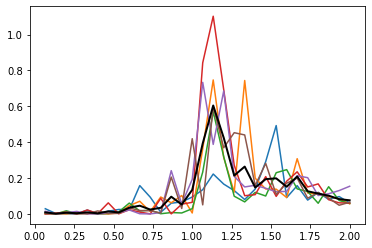

In [107]:
m=8
NIter=200
rep=30
rep+=1
gmax=2
ling=np.linspace(0,gmax,rep)


nrip=6

#ling=ling[int(30*rep/100):]
Evec=np.zeros((rep,nrip))
Entropy=np.zeros((rep,nrip))
ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks
for gm in ling:
    
    for rip in range(nrip):
        BlockSz = Sz
        BlockSx = Sx
        BlockI  = I
        BlockH = np.random.default_rng().normal(gm, .5)*Sx
        Energy = 0

        for l in range(NIter):
            SystSize = 2*l + 4

            g=np.random.default_rng().normal(gm, .5)

            
            # Get the 2m-dimensional operators for the block + site

            BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - np.kron(BlockSz, Sz) 
            BlockSz = np.kron(BlockI, Sz)
            BlockSx = np.kron(BlockI, Sx)
            BlockI  = np.kron(BlockI, I)

            # HAMILTONIAN MATRIX for superblock
            
            H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - np.kron(BlockSz, BlockSz)
            H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

            # Diagonalizing the Hamiltonian
            LastEnergy = Energy
            Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
            Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
            EnergyPerBond = (Energy - LastEnergy) / 2
            Ener2 = Energy / SystSize


            # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

            # Form the reduced density matrix
            nr=Psi.size
            Dim = int(np.sqrt(nr))
            PsiMatrix = np.reshape(Psi,(Dim,Dim))
            Rho = PsiMatrix @ PsiMatrix.T

            # Diagonalize the density matrix
            D,V = np.linalg.eigh(Rho)
            D=D[::-1]  # descending
            Index=np.arange(Dim)
            Index=Index[::-1]
            V=V[:,Index]

            # Construct the truncation operator
            NKeep = min(D.size, m)

            Omatr = V[:,:NKeep]

            TruncationError = 1 - sum(D[:NKeep])


            # Transform the block operators into the truncated basis
            BlockH  = Omatr.T @ BlockH  @ Omatr
            BlockSz = Omatr.T @ BlockSz @ Omatr
            BlockSx = Omatr.T @ BlockSx @ Omatr
            BlockI  = Omatr.T @ BlockI  @ Omatr


            
        #print(SystSize, Energy, EnergyPerBond, Ener2, TruncationError)

        Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
        Evec[ggg,rip]=Energy
        Entropy[ggg,rip]=Ent
    ggg+=1
    
    
    #Spectrum=ssl.eigsh(H_super)[0]
    
plt.plot(ling[1:],Entropy[1:])
plt.plot(ling[1:],np.sum(Entropy[1:],axis=1)/nrip,color='k', linewidth=2.0)
plt.show()

## Running $\sigma$

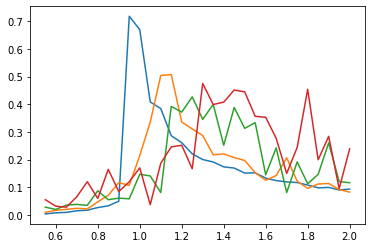

In [128]:
#%%time
m=8
NIter=200
rep=30
rep+=1
gmax=2
ling=np.linspace(0.5,gmax,rep)
linsig=np.linspace(0.1,1,4)


nrip=

#ling=ling[int(30*rep/100):]
Evec=np.zeros((rep,nrip))
Entropy=np.zeros((rep,nrip))
MEnt=np.zeros((4,rep-1))

ggg=0


# inizialize local ops

I=np.eye(2,2)
Sz=np.array([[1, 0],[0,-1]])
Sx=np.array([[0, 1],[1,0]])

# initial blocks

sss=0
for sig in linsig:
    ggg=0 
    for gm in ling: 

        for rip in range(nrip):
            BlockSz = Sz
            BlockSx = Sx
            BlockI  = I
            #BlockH  = gm*Sx
            BlockH = np.random.default_rng().normal(gm, sig)*Sx
            Energy = 0

            for l in range(NIter):
                SystSize = 2*l + 4

                g=np.random.default_rng().normal(gm, sig)


                # Get the 2m-dimensional operators for the block + site

                BlockH = np.kron(BlockH, I) + np.kron(BlockI, g*Sx) - np.kron(BlockSz, Sz) 
                BlockSz = np.kron(BlockI, Sz)
                BlockSx = np.kron(BlockI, Sx)
                BlockI  = np.kron(BlockI, I)

                # HAMILTONIAN MATRIX for superblock

                H_super = np.kron(BlockH, BlockI) + np.kron(BlockI, BlockH) - np.kron(BlockSz, BlockSz)
                H_super = 0.5 * (H_super + H_super.T);  # ensure H is symmetric

                # Diagonalizing the Hamiltonian
                LastEnergy = Energy
                Energy= ssl.eigsh(H_super,1,which='SA')[0] #[0]
                Psi = ssl.eigsh(H_super,1,which='SA')[1].T #[0]
                EnergyPerBond = (Energy - LastEnergy) / 2
                Ener2 = Energy / SystSize


                # Sigma = Psi' *kron(BlockSz,BlockSz) * Psi; % n.n. ZZ correlation function

                # Form the reduced density matrix
                nr=Psi.size
                Dim = int(np.sqrt(nr))
                PsiMatrix = np.reshape(Psi,(Dim,Dim))
                Rho = PsiMatrix @ PsiMatrix.T

                # Diagonalize the density matrix
                D,V = np.linalg.eigh(Rho)
                D=D[::-1]  # descending
                Index=np.arange(Dim)
                Index=Index[::-1]
                V=V[:,Index]

                # Construct the truncation operator
                NKeep = min(D.size, m)

                Omatr = V[:,:NKeep]

                TruncationError = 1 - sum(D[:NKeep])


                # Transform the block operators into the truncated basis
                BlockH  = Omatr.T @ BlockH  @ Omatr
                BlockSz = Omatr.T @ BlockSz @ Omatr
                BlockSx = Omatr.T @ BlockSx @ Omatr
                BlockI  = Omatr.T @ BlockI  @ Omatr



            #print(SystSize, Energy, EnergyPerBond, Ener2, TruncationError)

            Ent=-sum(D[:NKeep]*np.log(D[:NKeep]))
            #Evec[ggg,rip]=Energy
            Entropy[ggg,rip]=Ent
        ggg+=1
    
    MEnt[sss]=np.sum(Entropy[1:],axis=1)/nrip
    sss+=1
    
    #Spectrum=ssl.eigsh(H_super)[0]
    
plt.plot(ling[1:],MEnt.T)
#plt.legend()
plt.show()